<a href="https://colab.research.google.com/github/parmigggiana/ml-ids/blob/main/IDS_CTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web attack detection using CTF dataset

## Data preprocessing

In [32]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
#!wget https://github.com/parmigggiana/ml-ids/raw/main/CTF%20Data/ctf_flows_1.csv -O dataset_ctf.csv

In [34]:
#df = pd.read_csv('dataset_ctf.csv')
df = pd.read_csv('CTF Data/Thu15.csv')

In [35]:
df.shape

(79819, 89)

Make sure that there's no null rows

In [36]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(79819, 89)

Drop Label column since it's useless

In [37]:
df.drop(columns='Label', inplace=True)
df.shape

(79819, 88)

Drop all flows pertaining ssh and caronte

In [38]:
df.drop(df[df['Src Port'] == 22].index, inplace=True)
df.drop(df[df['Dst Port'] == 22].index, inplace=True)
df.drop(df[df['Src Port'] == 3333].index, inplace=True)
df.drop(df[df['Dst Port'] == 3333].index, inplace=True)
df.shape

(79472, 88)

Drop all flows made by our team

In [39]:
df.drop(df[df['Src IP'].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.drop(df[df['Dst IP'].str.fullmatch(r"10\.80\.39\.\d{1,3}")].index, inplace=True)
df.shape

(79471, 88)

In [40]:
df['Src IP'].unique()

array(['10.254.0.1', '10.80.35.2', '172.23.0.2', '10.80.24.6',
       '10.80.36.6', '10.80.24.12', '10.80.22.2', '10.80.36.8',
       '10.80.22.6', '10.80.35.3', '10.80.20.2', '10.80.6.4', '10.80.5.7',
       '10.80.22.4', '10.80.36.9', '10.80.32.2', '10.80.35.7',
       '10.80.22.7', '10.60.39.1', '10.80.21.4', '10.80.22.5',
       '10.80.36.7', '10.80.22.3', '10.80.30.2', '10.80.26.6'],
      dtype=object)

I noticed there's some flows belonging to other addresses. This probably means there's an error in the gameserver, leaking some packets. Upon manual inspection of the pcap, I noticed they are mostly FIN/ACK and RST. 
I chose to keep these flows as it's still actual traffic and we will be removing the IP features anyway

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [41]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [42]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [43]:
excluded = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
df.drop(columns=excluded, inplace=True)

## Feature Selection

Since we don't have labels, it would be hard to select features: an approach could be removing the ones with low variance or high correlation. 
For simplicity, I will be using the same features I used in the final model trained on the improved CIC-IDS-2017.

In [24]:
features = ['RST Flag Count', 'Total Length of Fwd Packet', 'Fwd Packet Length Max', 'Packet Length Variance', 'Fwd Packets/s', 'Fwd Packet Length Mean', 'Flow IAT Max', 'Flow Duration', 'Flow Packets/s', 'Total TCP Flow Time', 'PSH Flag Count', 'Packet Length Min', 'Bwd IAT Total', 'FWD Init Win Bytes', 'Flow Bytes/s', 'ACK Flag Count', 'Fwd Header Length', 'SYN Flag Count', 'Total Bwd packets']
df = df[features]

Let's do a sanity check

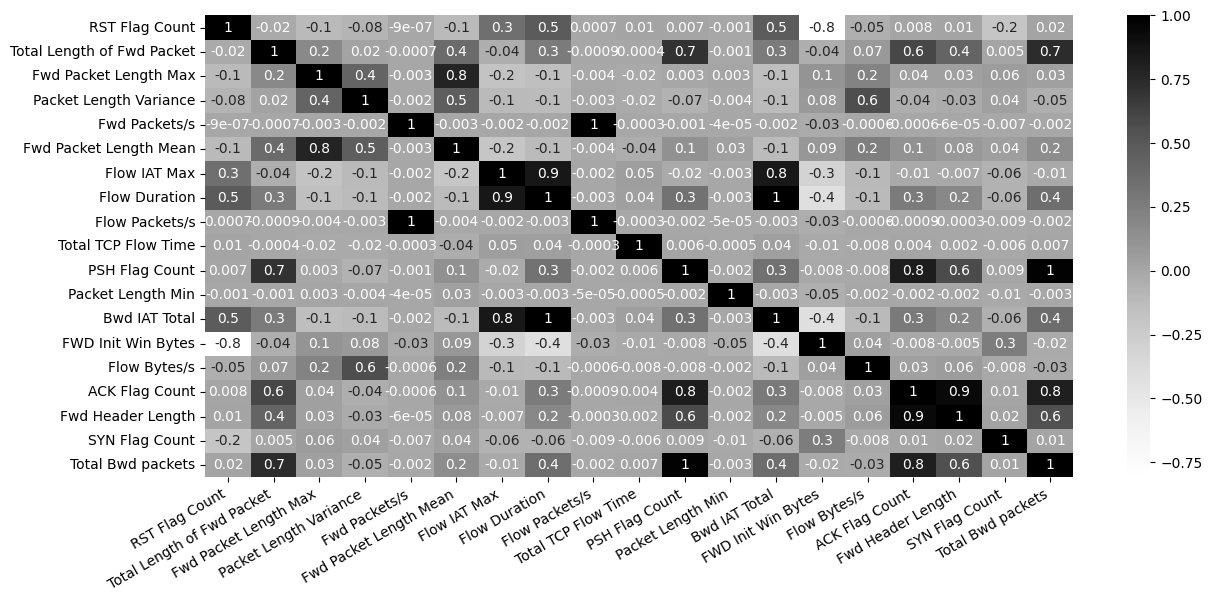

In [25]:
import seaborn as sns
corr_matrix = df.corr()
plt.rcParams['figure.figsize'] = (14, 6)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30)
plt.show()

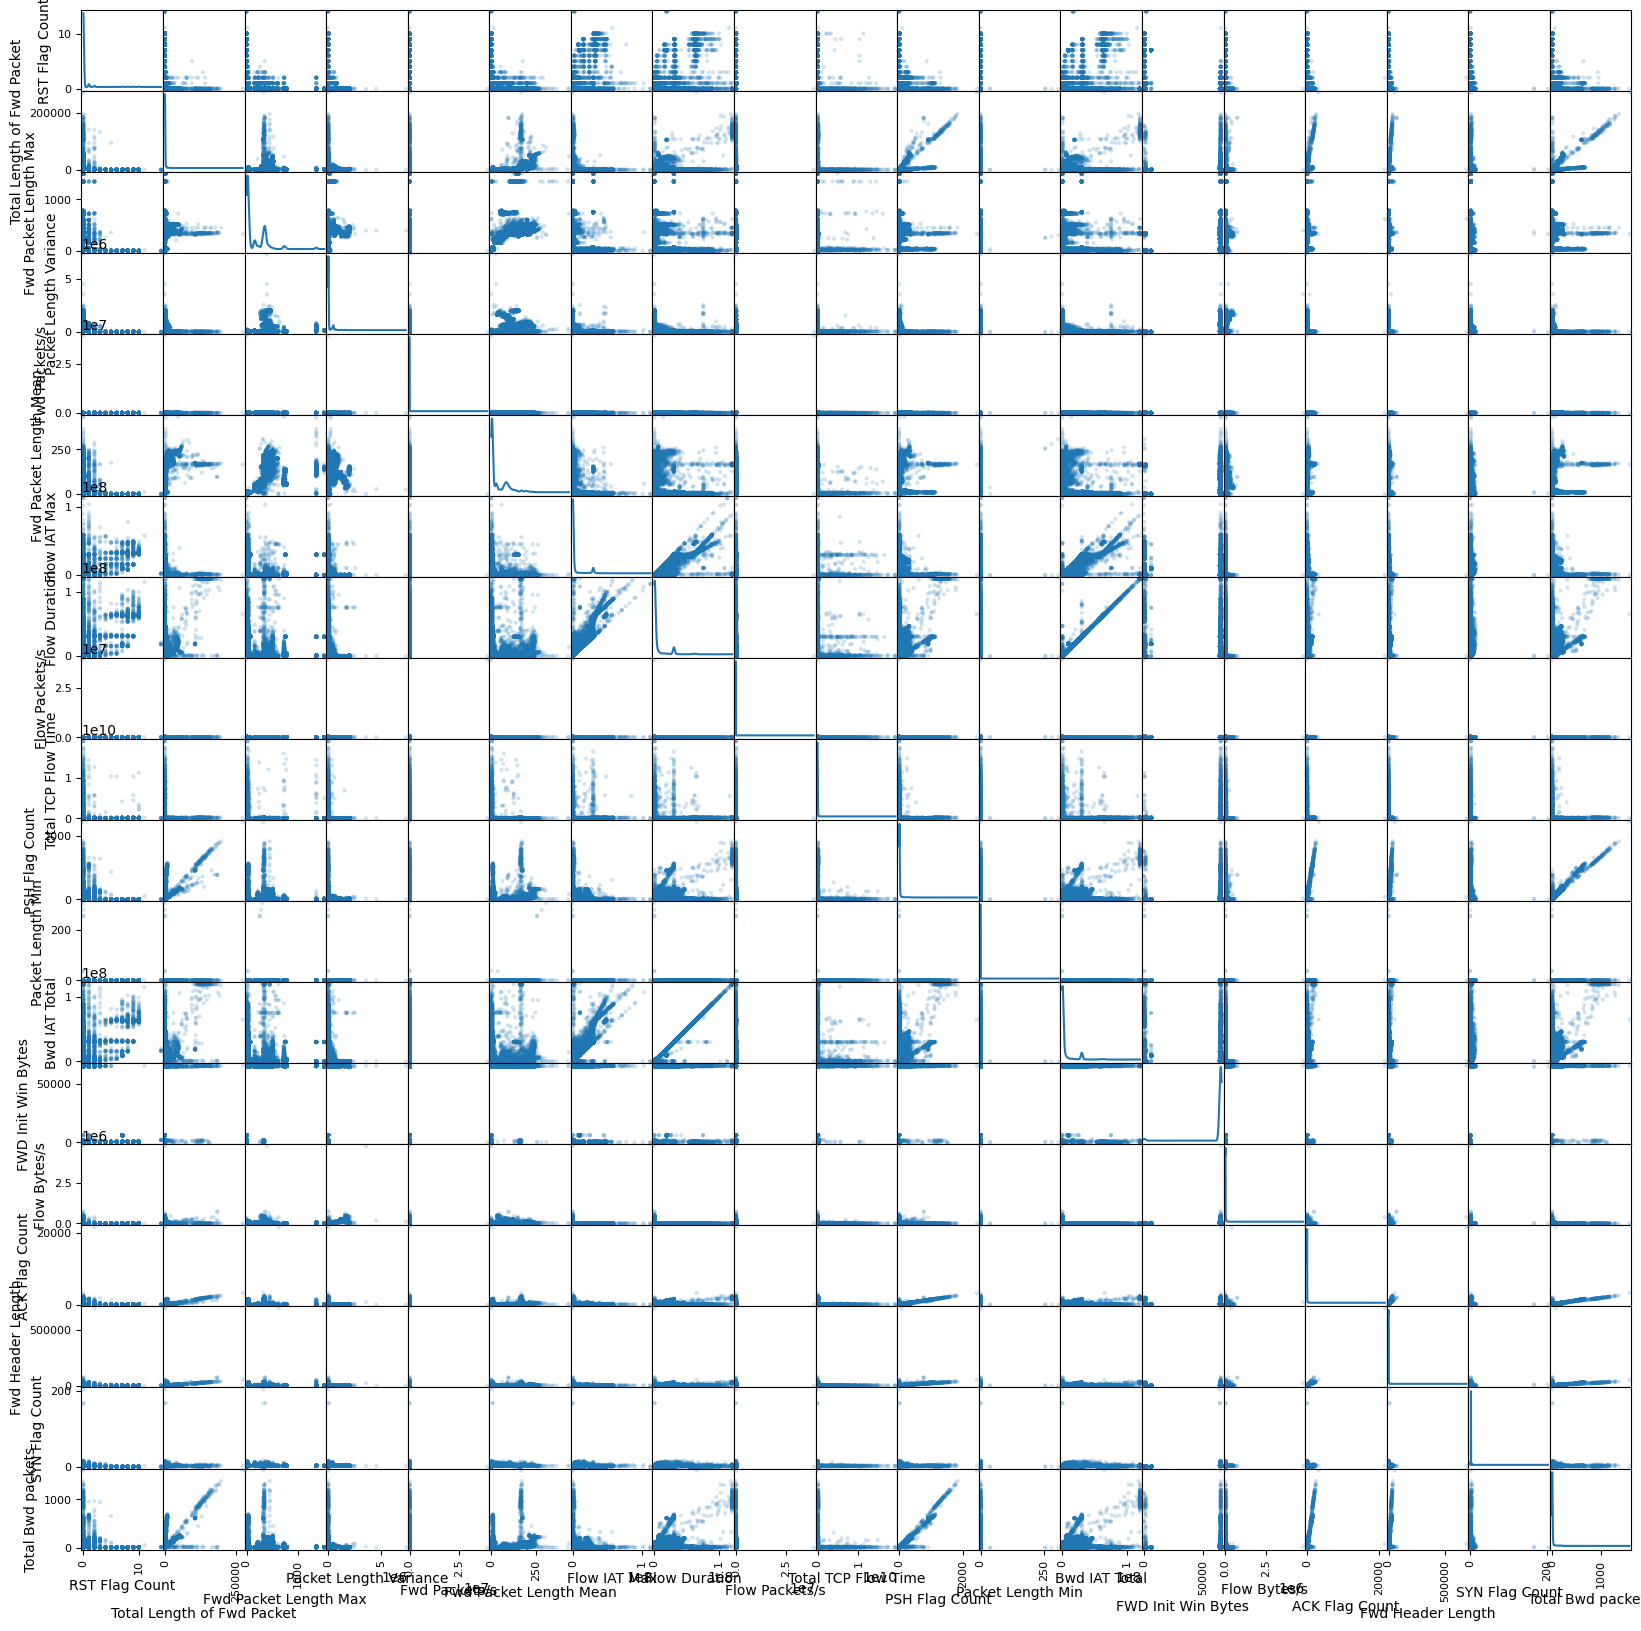

In [27]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal="kde")

## Dimensionality reduction

An alternative to selecting the features to use would be employing a dimensionality reduction algorithm.
Before that, we need to normalize our dataset.
I chose to use RobustScaler instead of StandardScaler because, by using the median, it is more resilient to inbalanced data.

### PCA

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

X = RobustScaler().fit_transform(df)

pca = PCA(15, random_state=42)
pca.fit(X)
X = pca.transform(X)
X.shape

(79471, 15)

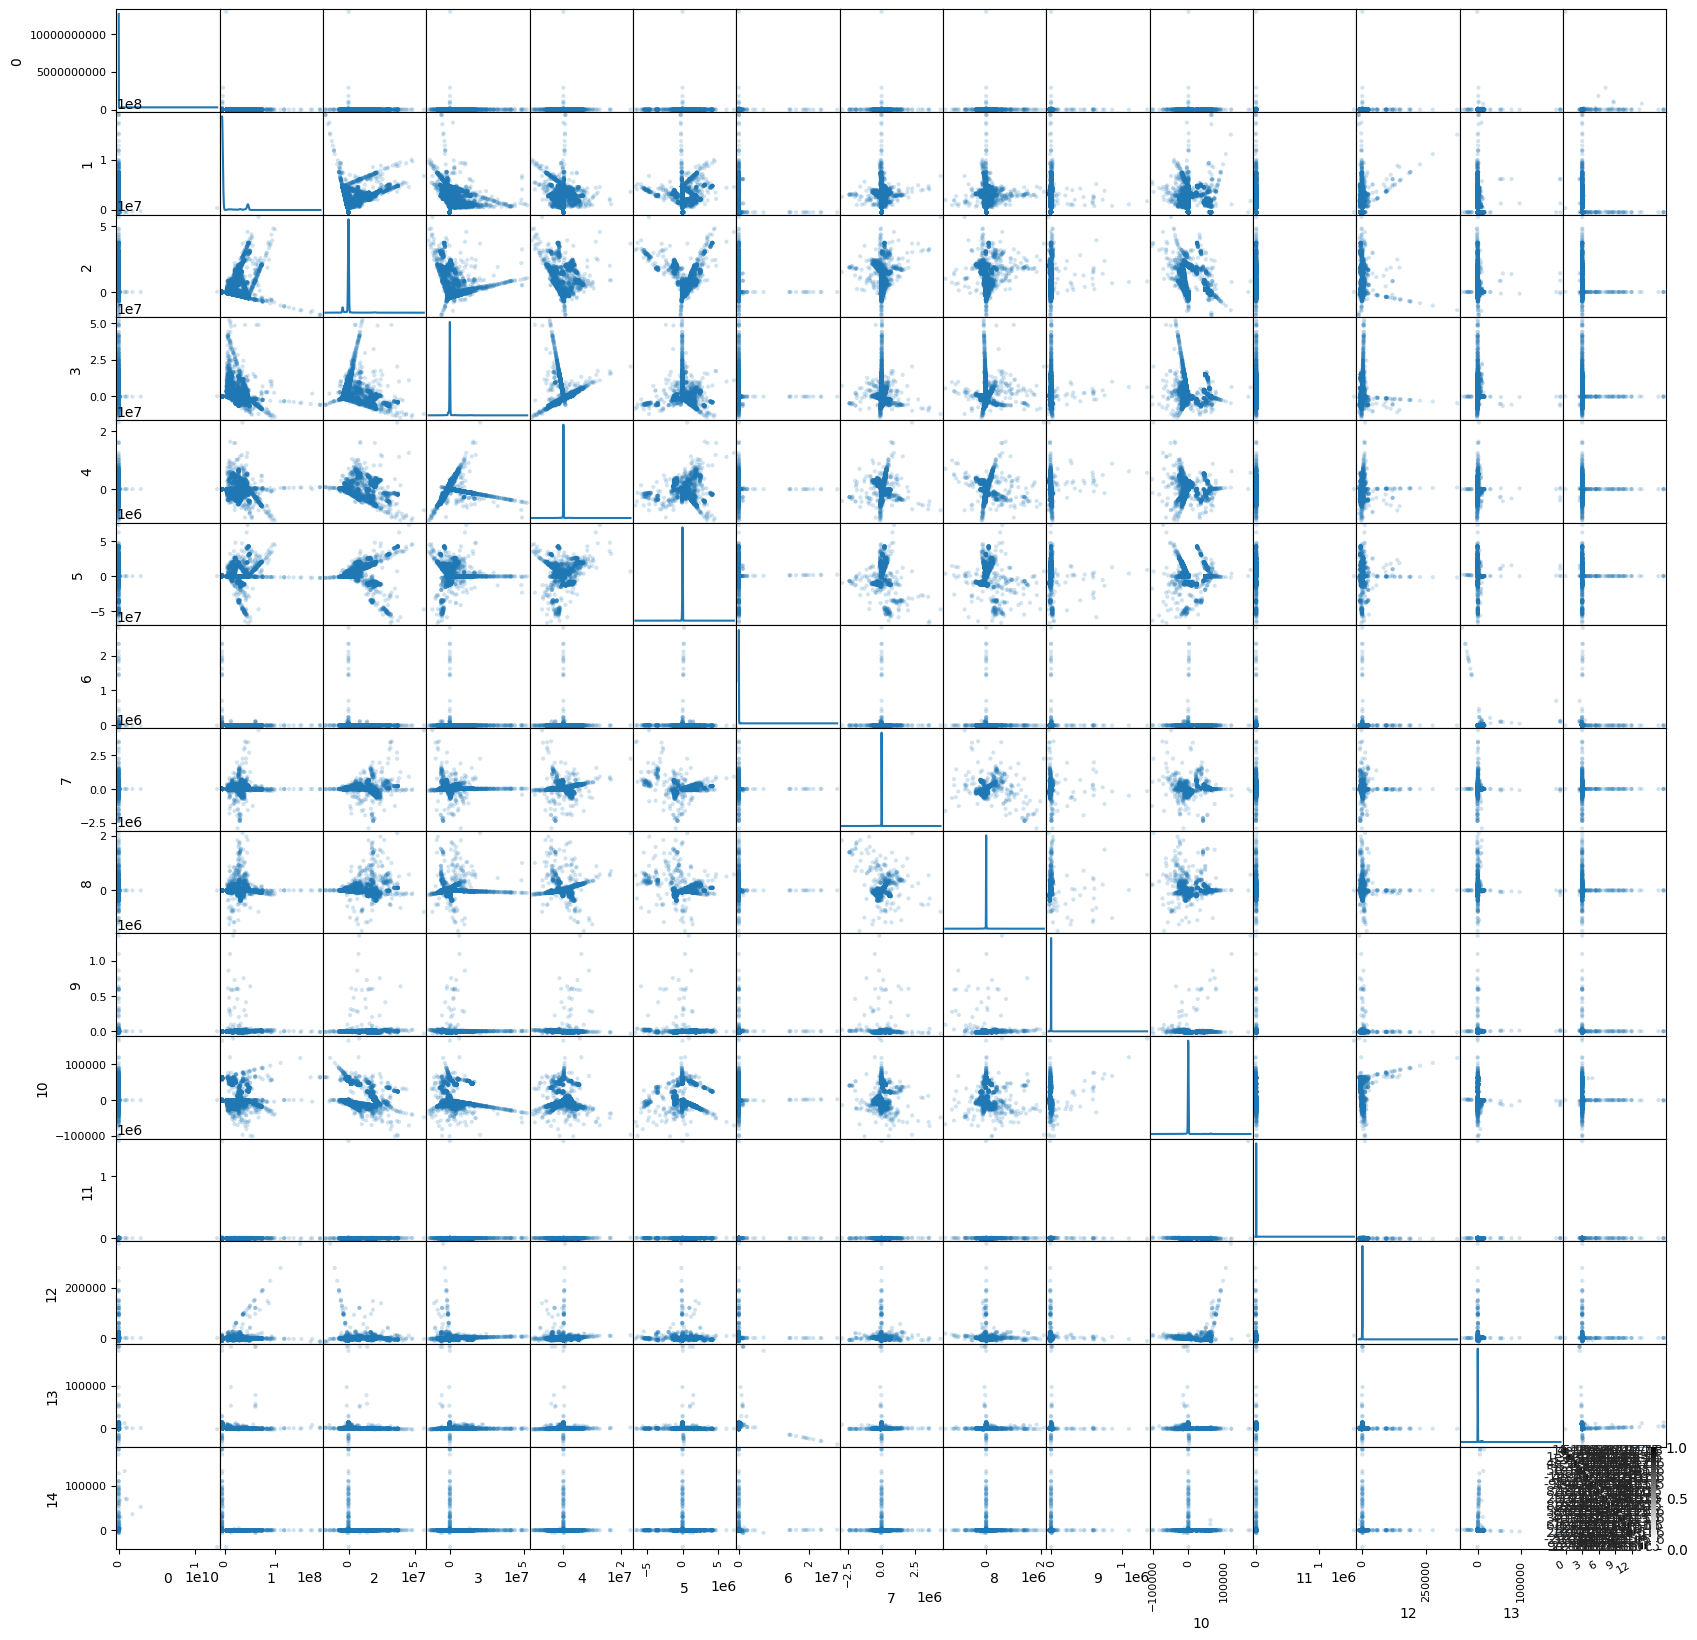

In [71]:
import seaborn as sns
from pandas.plotting import scatter_matrix

scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(20, 20), diagonal="kde")

corr_matrix = pd.DataFrame(X).corr()
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30)
plt.show()

### Feature Agglomeration

In [69]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import RobustScaler

X = RobustScaler().fit_transform(df)

fa = FeatureAgglomeration(n_clusters=15)
fa.fit(X)
X = fa.transform(X)
X.shape

(79471, 15)

In [ ]:
import seaborn as sns
from pandas.plotting import scatter_matrix

scatter_matrix(pd.DataFrame(X), alpha=0.2, figsize=(20, 20), diagonal="kde")

corr_matrix = pd.DataFrame(X).corr()
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30)
plt.show()

## Training


In [80]:
from sklearn.experimental import enable_halving_search_cv # experimental feature
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.cluster import KMeans, MiniBatchKMeans

clf = KMeans(2, random_state=42, verbose=10)

param_grid = {
    'algorithm': ['lloyd', 'elkan'], 
    'max_iter': [100, 300, 650, 1000], 
    'n_init': [1, 2, 5, 10, 20], 
}
search = HalvingGridSearchCV(clf, param_grid=param_grid, n_jobs=-1, verbose=10).fit(X)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2943
max_resources_: 79471
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 40
n_resources: 2943
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 2/5; 1/40] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 3/5; 1/40] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 4/5; 1/40] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 5/5; 1/40] START algorithm=lloyd, max_iter=100, n_init=1....................
[CV 1/5; 2/40] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 2/5; 2/40] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 3/5; 2/40] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 4/5; 2/40] START algorithm=lloyd, max_iter=100, n_init=2....................
[CV 5/

In [81]:
print(search.best_estimator_)
print(search.best_params_)


KMeans(max_iter=1000, n_clusters=2, n_init=1, random_state=42, verbose=10)
{'algorithm': 'lloyd', 'max_iter': 1000, 'n_init': 1}


In [ ]:


clf: KMeans = search.best_estimator_
clf.predict(X_test)